## Importing libraries

In [5]:
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation, LeakyReLU
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import time
import codecs
import itertools
import pickle

from keras import regularizers

import os
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import glob
import librosa.display
import scipy.io.wavfile
import numpy as np
import sys

import numpy as np
from matplotlib import pyplot as plt
# !pip install sidekit                # To be included while running
# from sidekit.frontend.io import *
# from sidekit.frontend import *

# from praat import *
# from sidekit.frontend import *
# from energy_operators import general_nleo
# from energy_operators import edo
# from test_functions import gen_test_signals
# from test_functions import test_edo


Importing All Audio files

In [6]:
main_path="/content/drive/MyDrive/NLP_Project/All_audios"
mylist = os.listdir(main_path)

def read_file(filename):
	training = ""
	try:
		fp = codecs.open(filename, 'r', encoding = 'utf-8', errors = 'ignore')
		training = fp.read()
	except:
		print("File not found")
		text = "File not found"
		exit()
	return training

# Actor-Gender mapping file for CREMA-D database
mapping = read_file("/content/drive/MyDrive/NLP_Project/VideoDemographics.csv")
mapping = mapping.split("\n")

male = {}
female = {}
for i in range(len(mapping)):
	mapping[i] = mapping[i][:-1]
	mapping[i] = mapping[i].split(",")

	if(len(mapping[i])>1 and mapping[i][1] == "Male"):
		male[mapping[i][0]] = 0
	elif(len(mapping[i])>1):
		female[mapping[i][0]] = 0


print(mylist)
print("Total audio files:", len(mylist))


['03-01-04-02-02-02-08.wav', '03-01-05-02-01-02-08.wav', '03-01-04-02-01-02-08.wav', '03-01-04-01-02-02-08.wav', '03-01-05-02-01-01-08.wav', '03-01-04-01-02-01-08.wav', '03-01-04-01-01-01-08.wav', '03-01-05-01-01-01-08.wav', '03-01-05-01-02-01-08.wav', '03-01-05-02-02-01-08.wav', '03-01-03-02-02-01-08.wav', '03-01-03-02-02-02-08.wav', '03-01-04-02-01-01-08.wav', '03-01-04-02-02-01-08.wav', '03-01-06-02-01-01-08.wav', '03-01-07-01-01-01-08.wav', '03-01-05-02-02-02-08.wav', '03-01-06-01-02-02-08.wav', '03-01-07-01-02-01-08.wav', '03-01-07-01-02-02-08.wav', '03-01-06-01-01-01-08.wav', '03-01-06-02-02-02-08.wav', '03-01-07-02-01-02-08.wav', '03-01-07-02-01-01-08.wav', '03-01-06-01-01-02-08.wav', '03-01-07-02-02-01-08.wav', '03-01-07-02-02-02-08.wav', '03-01-07-01-01-02-08.wav', '03-01-06-01-02-01-08.wav', '03-01-06-02-02-01-08.wav', '03-01-06-02-01-02-08.wav', '03-01-02-01-02-01-09.wav', '03-01-02-01-02-02-09.wav', '03-01-08-01-01-01-08.wav', '03-01-08-01-02-02-08.wav', '03-01-01-01-01-01-

## Plotting the audio file's waveform and its spectrogram

Loading the file to be plotted

In [7]:
data, sampling_rate = librosa.load(main_path+'/'+mylist[0])

Plotting

**Waveform** along the time axis

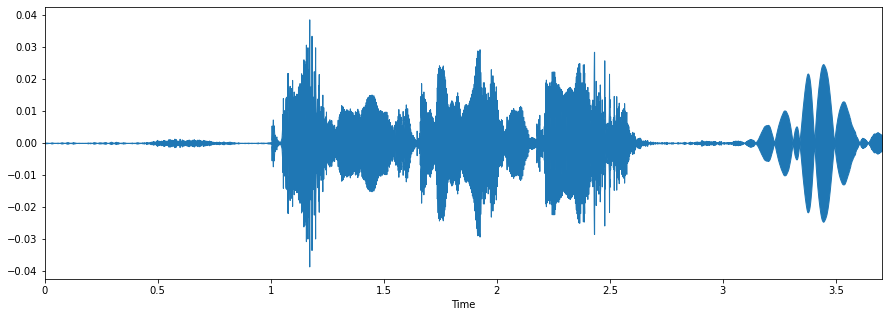

In [8]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

**Spectrogram** along the time axis

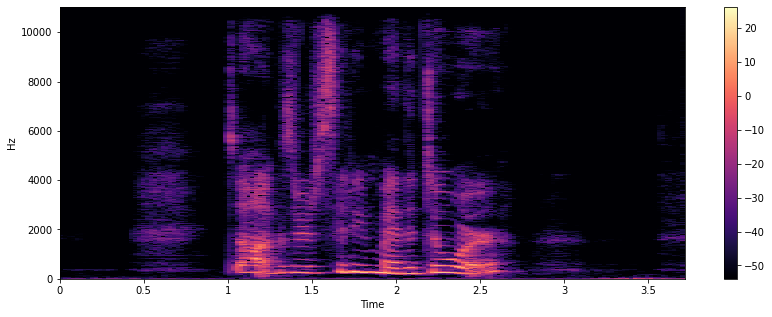

In [9]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()

**Log scaled Spectrogram** along the time axis

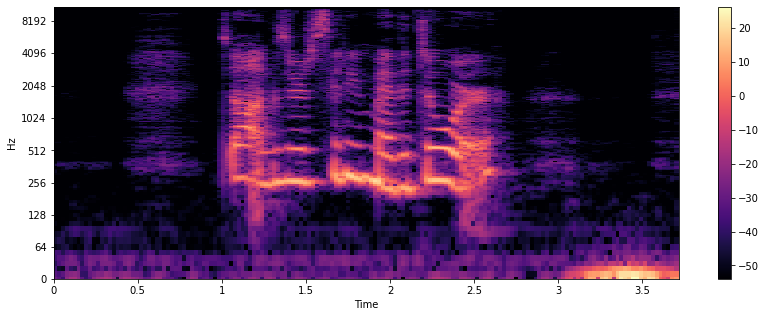

In [10]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar()

## Setting the labels

Extracting labels for all the audio files to be included

In [11]:
feeling_list=[]
map = {('02',0):'female_calm',('02',1):'male_calm',('03',0):'female_happy',('03',1):'male_happy',('04',0):'female_sad',('04',1):'male_sad',
       ('05',0):'female_angry',('05',1):'male_angry',('06',0):'female_fearful',('06',1):'male_fearful',
        'a':'male_angry','f':'male_fearful','h':'male_happy','sa':'male_sad'}

dataset_used = []
for item in mylist:
    if len(item)==24 and (item[6:-16],int(item[18:-4])%2) in map:
      dataset_used.append(item)
      feeling_list.append(map[(item[6:-16],int(item[18:-4])%2)])
    elif item[:1] in map:
      dataset_used.append(item)
      feeling_list.append(map[item[:1]])
    elif item[:2] in map:
      dataset_used.append(item)
      feeling_list.append(map[item[:2]])
    elif(item.count("_") == 3):
      actor = item[:4]
      gen = "male"
      if(female.get(actor) != None):
        gen = "female"

      emotion = ""

      if(item.find("HAP")!=-1 and item.find("HI")!=-1):
        emotion = "happy"
      elif(item.find("SAD")!=-1 and item.find("HI")!=-1):
        emotion = "sad"
      elif(item.find("ANG")!=-1 and item.find("HI")!=-1):
        emotion = "angry"
      elif(item.find("FEA")!=-1 and item.find("HI")!=-1):
        emotion = "fearful"
      if(emotion != ""):
        dataset_used.append(item)
        feeling_list.append(gen + "_" + emotion)

labels = pd.DataFrame({'label': feeling_list})
print("Number of audio files included:", len(feeling_list))
print("All possible labels: ", list(set(feeling_list)))

Number of audio files included: 1384
All possible labels:  ['female_fearful', 'male_calm', 'male_happy', 'male_angry', 'female_happy', 'male_fearful', 'female_angry', 'male_sad', 'female_calm', 'female_sad']


In [12]:
labels[:10]

,label
0,female_sad
1,female_angry
2,female_sad
3,female_sad
4,female_angry
5,female_sad
6,female_sad
7,female_angry
8,female_angry
9,female_angry


## Getting the features of audio files using librosa

**Total features tried:**

1.   MFCCS
2.   Mel Spec
3.   Chromagram
4.   Spectral Rolloff
5.   Zero Cross S
6.   Energy
7.   Spectral Centroid

**Out of these several combinations were tried, best feature combination was:**


1.   MFCCS
2.   Energy






In [ ]:

df = pd.DataFrame(columns=['feature'])
bookmark=0
c = 0
start_time = time.time()
for index,y in enumerate(dataset_used):
    X, sample_rate = librosa.load(main_path+'/'+y, res_type='kaiser_best',duration=2.5,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)

    mfcc_feature = librosa.feature.mfcc(y=X, sr=sample_rate,dct_type=2,norm='ortho', n_mfcc=15)
    mfccs = np.mean(mfcc_feature,axis=0)
    # hnr=readHarmonicityData(y)
    # print(len(hnr[1]))
    # x_edo = edo.gen_edo(X, True)
    # x_edo1=x_edo[0]
    # x_nleo = general_nleo.specific_nleo(X, type='teager')
    # x_nleo1=x_nleo[0]
    # print(len(x_nleo),len(x_edo))

    try:
        plp_features = features.plp(X,rasta=False,fs=sample_rate)
    except:
        print("")
    mel_spec= librosa.feature.melspectrogram(y=X, sr=sample_rate)[0]
    
    chromagram = librosa.feature.chroma_stft(y=X, sr=sample_rate)[0]
    
    spectral_rolloff = librosa.feature.spectral_rolloff(y=X, sr=sampling_rate)[0]
                  
    zero_cross = librosa.feature.zero_crossing_rate(y=X,center=True)
    zero_cross_s = zero_cross[0]

    stft = librosa.stft(X)
    energy = librosa.feature.rmse(S= stft)
    energys = energy[0]

    spectral_centroid = librosa.feature.spectral_centroid(y=X,sr=sampling_rate)
    spectral_centroids = spectral_centroid[0]

    #mfccs,zero_cross_s,energys,spectral_centroids,mel_spec,chromagram,spectral_rolloff

    feature = list(itertools.chain(mfccs,energys))
    # print(len(feature))
    df.loc[bookmark] = [feature]
    if(bookmark%25==0):
        print(bookmark)
    bookmark=bookmark+1
    # print(df["feature"][0])
    # print(len(df["feature"][0]))
    # break
            
end_time = time.time()
print("Time taken: ", end_time - start_time)

Time taken:  429.8831868171692


In [ ]:
df3 = pd.DataFrame(df['feature'].values.tolist())
print("Feature Matrix:")
df3[:5]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431
0,-41.916029,-42.720251,-44.134782,-43.356630,-41.519287,-41.382523,-42.971226,-41.494845,-40.112007,-42.490165,-41.222184,-39.994388,-41.296296,-41.149056,-40.985169,-41.307526,-42.311792,-44.254157,-46.624736,-43.631549,-44.533047,-46.108207,-45.807512,-48.282699,-47.929808,-46.244256,-44.942508,-44.268176,-46.066034,-47.343536,-47.254934,-46.456347,-46.447616,-47.782634,-45.359170,-46.220059,-46.803634,-45.696713,-46.879944,-45.520421,...,0.148373,0.162066,0.177228,0.144181,0.073324,0.049502,0.035058,0.021362,0.018331,0.011810,0.009538,0.007510,0.005572,0.005693,0.007534,0.004985,0.003421,0.003699,0.003599,0.002359,0.002229,0.001723,0.001748,0.002121,0.002699,0.003229,0.003231,0.003835,0.004359,0.004991,0.004904,0.006751,0.007383,0.007735,0.007301,0.006184,0.006123,0.005675,0.005895,0.006238
1,-35.558602,-34.400064,-34.072053,-35.258230,-35.881312,-35.207021,-34.477047,-35.009424,-34.005166,-34.162143,-34.542952,-34.150494,-34.184923,-34.548425,-33.677869,-34.070109,-33.511885,-34.760148,-34.068312,-33.685731,-34.138633,-34.246235,-34.592144,-33.797377,-34.493489,-33.854626,-33.517921,-33.943922,-33.816071,-32.878304,-32.650486,-32.373246,-33.452341,-34.286959,-33.732003,-33.488246,-32.759706,-29.800975,-29.422812,-28.180164,...,3.250463,2.428080,1.631993,1.013621,0.611084,0.459615,0.399270,0.487077,0.461598,0.344928,0.152309,0.094028,0.071196,0.062246,0.061276,0.055745,0.038504,0.019941,0.011603,0.007860,0.005561,0.005500,0.006574,0.006775,0.010289,0.010008,0.011944,0.012220,0.007257,0.006068,0.005271,0.005744,0.007015,0.008803,0.007840,0.007607,0.007442,0.006388,0.006955,0.005878
2,-39.303441,-40.905031,-43.228789,-46.154849,-44.327816,-43.103095,-43.652717,-44.001453,-43.245760,-40.454938,-41.887760,-43.120228,-46.589848,-46.085901,-43.539627,-44.163913,-44.716376,-43.825196,-44.709993,-44.194670,-43.120742,-41.653960,-40.946792,-42.193311,-43.069325,-44.005650,-45.697129,-47.332929,-46.616634,-44.450994,-43.304901,-44.334592,-45.081926,-43.463021,-45.319538,-44.140160,-43.036558,-41.864611,-41.314651,-41.389267,...,0.152964,0.149878,0.151720,0.145910,0.115511,0.086475,0.095210,0.103899,0.088228,0.098789,0.080061,0.094883,0.080378,0.110686,0.142002,0.145845,0.087981,0.045052,0.022953,0.016755,0.018943,0.017136,0.011921,0.006618,0.005144,0.005650,0.005689,0.005343,0.003445,0.004211,0.003035,0.002990,0.003105,0.002170,0.002286,0.002378,0.004100,0.004250,0.003831,0.006290
3,-49.522779,-47.501824,-44.480466,-44.253602,-43.086545,-44.625264,-45.279341,-45.590903,-47.901055,-49.259059,-48.524933,-48.701661,-47.577503,-49.123080,-47.540269,-46.092463,-46.949208,-46.205654,-46.387952,-47.211011,-48.605173,-47.069089,-46.378006,-44.140665,-44.471916,-43.744319,-43.511967,-44.734346,-45.230367,-45.908288,-47.272357,-47.952534,-47.347637,-45.711801,-45.200378,-45.457113,-45.719510,-47.461867,-49.273931,-46.743017,...,0.004327,0.004084,0.003354,0.001616,0.002649,0.003216,0.003912,0.003578,0.003272,0.004641,0.003770,0.004907,0.005244,0.006632,0.005885,0.006698,0.006019,0.006087,0.007652,0.004764,0.004084,0.002036,0.001143,0.002607,0.002491,0.003204,0.003025,0.001818,0.002098,0.001894,0.001841,0.003102,0.002386,0.002625,0.002792,0.002428,0.002454,0.002640,0.003202,0.002063
4,-41.351557,-41.241564,-41.364739,-39.740632,-39.315369,-37.884899,-38.006132,-39.153154,-38.455972,-40.381808,-40.413725,-39.853213,-39.812208,-37.894685,-38.011766,-40.098447,-40.032301,-39.923188,-38.501020,-38.243528,-39.754110,-38.571606,-38.837028,-37.500741,-38.137593,-39.400617,-39.039607,-38.829982,-39.555539,-38.386905,-40.076118,-39.300118,-37.643520,-38.575479,-39.936775,-40.616528,-41.406455,-40.116681,-37.485053,-35.361845,...,2.018192,1.739390,1.689138,1.539585,1.419736,1.246246,1

Combining features and labels in a single matrix

In [ ]:
newdf = pd.concat([df3,labels], axis=1)
print(len(newdf))
newdf[:5]

1384


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,label
0,-41.916029,-42.720251,-44.134782,-43.356630,-41.519287,-41.382523,-42.971226,-41.494845,-40.112007,-42.490165,-41.222184,-39.994388,-41.296296,-41.149056,-40.985169,-41.307526,-42.311792,-44.254157,-46.624736,-43.631549,-44.533047,-46.108207,-45.807512,-48.282699,-47.929808,-46.244256,-44.942508,-44.268176,-46.066034,-47.343536,-47.254934,-46.456347,-46.447616,-47.782634,-45.359170,-46.220059,-46.803634,-45.696713,-46.879944,-45.520421,...,0.162066,0.177228,0.144181,0.073324,0.049502,0.035058,0.021362,0.018331,0.011810,0.009538,0.007510,0.005572,0.005693,0.007534,0.004985,0.003421,0.003699,0.003599,0.002359,0.002229,0.001723,0.001748,0.002121,0.002699,0.003229,0.003231,0.003835,0.004359,0.004991,0.004904,0.006751,0.007383,0.007735,0.007301,0.006184,0.006123,0.005675,0.005895,0.006238,female_sad
1,-35.558602,-34.400064,-34.072053,-35.258230,-35.881312,-35.207021,-34.477047,-35.009424,-34.005166,-34.162143,-34.542952,-34.150494,-34.184923,-34.548425,-33.677869,-34.070109,-33.511885,-34.760148,-34.068312,-33.685731,-34.138633,-34.246235,-34.592144,-33.797377,-34.493489,-33.854626,-33.517921,-33.943922,-33.816071,-32.878304,-32.650486,-32.373246,-33.452341,-34.286959,-33.732003,-33.488246,-32.759706,-29.800975,-29.422812,-28.180164,...,2.428080,1.631993,1.013621,0.611084,0.459615,0.399270,0.487077,0.461598,0.344928,0.152309,0.094028,0.071196,0.062246,0.061276,0.055745,0.038504,0.019941,0.011603,0.007860,0.005561,0.005500,0.006574,0.006775,0.010289,0.010008,0.011944,0.012220,0.007257,0.006068,0.005271,0.005744,0.007015,0.008803,0.007840,0.007607,0.007442,0.006388,0.006955,0.005878,female_angry
2,-39.303441,-40.905031,-43.228789,-46.154849,-44.327816,-43.103095,-43.652717,-44.001453,-43.245760,-40.454938,-41.887760,-43.120228,-46.589848,-46.085901,-43.539627,-44.163913,-44.716376,-43.825196,-44.709993,-44.194670,-43.120742,-41.653960,-40.946792,-42.193311,-43.069325,-44.005650,-45.697129,-47.332929,-46.616634,-44.450994,-43.304901,-44.334592,-45.081926,-43.463021,-45.319538,-44.140160,-43.036558,-41.864611,-41.314651,-41.389267,...,0.149878,0.151720,0.145910,0.115511,0.086475,0.095210,0.103899,0.088228,0.098789,0.080061,0.094883,0.080378,0.110686,0.142002,0.145845,0.087981,0.045052,0.022953,0.016755,0.018943,0.017136,0.011921,0.006618,0.005144,0.005650,0.005689,0.005343,0.003445,0.004211,0.003035,0.002990,0.003105,0.002170,0.002286,0.002378,0.004100,0.004250,0.003831,0.006290,female_sad
3,-49.522779,-47.501824,-44.480466,-44.253602,-43.086545,-44.625264,-45.279341,-45.590903,-47.901055,-49.259059,-48.524933,-48.701661,-47.577503,-49.123080,-47.540269,-46.092463,-46.949208,-46.205654,-46.387952,-47.211011,-48.605173,-47.069089,-46.378006,-44.140665,-44.471916,-43.744319,-43.511967,-44.734346,-45.230367,-45.908288,-47.272357,-47.952534,-47.347637,-45.711801,-45.200378,-45.457113,-45.719510,-47.461867,-49.273931,-46.743017,...,0.004084,0.003354,0.001616,0.002649,0.003216,0.003912,0.003578,0.003272,0.004641,0.003770,0.004907,0.005244,0.006632,0.005885,0.006698,0.006019,0.006087,0.007652,0.004764,0.004084,0.002036,0.001143,0.002607,0.002491,0.003204,0.003025,0.001818,0.002098,0.001894,0.001841,0.003102,0.002386,0.002625,0.002792,0.002428,0.002454,0.002640,0.003202,0.002063,female_sad
4,-41.351557,-41.241564,-41.364739,-39.740632,-39.315369,-37.884899,-38.006132,-39.153154,-38.455972,-40.381808,-40.413725,-39.853213,-39.812208,-37.894685,-38.011766,-40.098447,-40.032301,-39.923188,-38.501020,-38.243528,-39.754110,-38.571606,-38.837028,-37.500741,-38.137593,-39.400617,-39.039607,-38.829982,-39.555539,-38.386905,-40.076118,-39.300118,-37.643520,-38.575479,-39.936775,-40.616528,-41.406455,-40.116681,-37.485053,-35.361845,...,1.739390,1.689138,1.539585,1.419736,1.24624

Shuffling rows

In [ ]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
print(len(rnewdf))
rnewdf[:10]


1384


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,label
1256,-50.003302,-49.486253,-48.329435,-48.622100,-46.038309,-46.497840,-48.550687,-46.858530,-45.531330,-46.169333,-48.711832,-47.992681,-47.548549,-48.281332,-47.061414,-44.833372,-46.063531,-42.259157,-39.944993,-39.992791,-37.511738,-35.173795,-35.153881,-34.734422,-34.563237,-36.061821,-37.593125,-39.100079,-41.697040,-42.688355,-42.693036,-39.766072,-37.121874,-40.390452,-42.714953,-42.820979,-43.292448,-41.030160,-38.257264,-38.453179,...,0.240003,0.503667,0.776744,0.987639,1.028818,0.941504,0.735622,0.559371,0.529766,0.488474,0.362719,0.336858,0.322788,0.341309,0.373886,0.391736,0.411937,0.452948,0.498543,0.498766,0.481783,0.407780,0.389603,0.355914,0.353080,0.344462,0.336534,0.326613,0.292223,0.275157,0.227264,0.164442,0.135627,0.093181,0.062575,0.041556,0.032026,0.027653,0.026571,male_happy
201,-42.741547,-42.863375,-44.939992,-48.023371,-51.201289,-50.559721,-48.352506,-48.083323,-48.556965,-46.460612,-45.060647,-47.263870,-48.392045,-48.790006,-52.573548,-50.422790,-50.334934,-54.831006,-57.687448,-57.110458,-55.795557,-51.971059,-47.459190,-48.730420,-49.904897,-50.319235,-51.343670,-51.201095,-54.466698,-56.430948,-60.134105,-59.874296,-54.912323,-56.222724,-60.512737,-59.689249,-55.639521,-54.496949,-53.422425,-51.017038,...,0.000878,0.001117,0.000686,0.000986,0.001333,0.001360,0.000981,0.000965,0.000797,0.000695,0.000685,0.000747,0.000613,0.001149,0.001492,0.000896,0.000610,0.000792,0.000752,0.001600,0.001450,0.000793,0.000654,0.001165,0.002005,0.001110,0.000145,0.000327,0.000569,0.000657,0.000494,0.000812,0.000829,0.000272,0.000050,0.000355,0.000559,0.000343,0.000509,male_sad
1075,-27.957638,-27.139863,-27.405466,-28.124754,-27.032492,-26.128426,-25.081992,-22.542279,-21.994609,-22.609941,-22.381002,-23.637068,-26.000887,-29.078245,-30.070124,-31.380066,-32.687883,-34.900701,-35.580985,-36.353413,-38.609572,-40.577300,-37.767882,-30.906418,-27.792424,-25.982611,-25.294041,-25.946787,-25.726405,-25.557963,-25.680056,-26.849589,-26.602516,-25.198268,-24.724434,-25.019379,-26.219966,-27.147601,-26.968102,-27.425344,...,0.122768,0.180310,0.205479,0.176428,0.126022,0.089103,0.073318,0.060434,0.057927,0.061073,0.060171,0.060847,0.062913,0.062982,0.059909,0.057799,0.070096,0.197874,0.339385,0.337913,0.298660,0.265084,0.236184,0.196123,0.159722,0.137610,0.146677,0.152473,0.162514,0.173725,0.150248,0.108414,0.083412,0.068624,0.061050,0.055220,0.054089,0.053316,0.052742,male_sad
230,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-59.753037,-57.670330,-56.577121,...,0.068746,0.068771,0.066940,0.062924,0.058596,0.054494,0.051634,0.047965,0.043172,0.039629,0.037170,0.034337,0.031050,0.027897,0.023971,0.021573,0.020515,0.020811,0.020657,0.018971,0.015140,0.009503,0.005507,0.003534,0.002895,0.003122,0.002220,0.001822,0.001419,0.001252,0.001013,0.000850,0.000526,0.000422,0.000413,0.000414,0.000330,0.000233,0.000324,female_calm
964,-14.359459,-14.564793,-15.613156,-16.097450,-15.489523,-14.305005,-12.777077,-11.475122,-12.521545,-13.480052,-13.345854,-14.434113,-13.396868,-11.653523,-13.931148,-14.684889,-13.193096,-12.155760,-12.643802,-12.443490,-13.323658,-14.511080,-15.833003,-15.954260,-12.709687,-11.126112,-9.706843,-8.814145,-10.060479,-10.340811,-11.850293,-13.059836,-13.682521,-13.438090,-14.801908,-15.853763,-14.344443,-12.482728,-12.422084,-13.329572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [ ]:
newdf1 = np.random.rand(len(rnewdf)) < 0.9
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

# Number of training samples
print(len(train))

1250


In [ ]:
trainfeatures = train.iloc[:, :-1] 
trainfeatures[:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431
1256,-50.003302,-49.486253,-48.329435,-48.622100,-46.038309,-46.497840,-48.550687,-46.858530,-45.531330,-46.169333,-48.711832,-47.992681,-47.548549,-48.281332,-47.061414,-44.833372,-46.063531,-42.259157,-39.944993,-39.992791,-37.511738,-35.173795,-35.153881,-34.734422,-34.563237,-36.061821,-37.593125,-39.100079,-41.697040,-42.688355,-42.693036,-39.766072,-37.121874,-40.390452,-42.714953,-42.820979,-43.292448,-41.030160,-38.257264,-38.453179,...,0.088321,0.240003,0.503667,0.776744,0.987639,1.028818,0.941504,0.735622,0.559371,0.529766,0.488474,0.362719,0.336858,0.322788,0.341309,0.373886,0.391736,0.411937,0.452948,0.498543,0.498766,0.481783,0.407780,0.389603,0.355914,0.353080,0.344462,0.336534,0.326613,0.292223,0.275157,0.227264,0.164442,0.135627,0.093181,0.062575,0.041556,0.032026,0.027653,0.026571
201,-42.741547,-42.863375,-44.939992,-48.023371,-51.201289,-50.559721,-48.352506,-48.083323,-48.556965,-46.460612,-45.060647,-47.263870,-48.392045,-48.790006,-52.573548,-50.422790,-50.334934,-54.831006,-57.687448,-57.110458,-55.795557,-51.971059,-47.459190,-48.730420,-49.904897,-50.319235,-51.343670,-51.201095,-54.466698,-56.430948,-60.134105,-59.874296,-54.912323,-56.222724,-60.512737,-59.689249,-55.639521,-54.496949,-53.422425,-51.017038,...,0.000939,0.000878,0.001117,0.000686,0.000986,0.001333,0.001360,0.000981,0.000965,0.000797,0.000695,0.000685,0.000747,0.000613,0.001149,0.001492,0.000896,0.000610,0.000792,0.000752,0.001600,0.001450,0.000793,0.000654,0.001165,0.002005,0.001110,0.000145,0.000327,0.000569,0.000657,0.000494,0.000812,0.000829,0.000272,0.000050,0.000355,0.000559,0.000343,0.000509
230,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-62.666016,-59.753037,-57.670330,-56.577121,...,0.066698,0.068746,0.068771,0.066940,0.062924,0.058596,0.054494,0.051634,0.047965,0.043172,0.039629,0.037170,0.034337,0.031050,0.027897,0.023971,0.021573,0.020515,0.020811,0.020657,0.018971,0.015140,0.009503,0.005507,0.003534,0.002895,0.003122,0.002220,0.001822,0.001419,0.001252,0.001013,0.000850,0.000526,0.000422,0.000413,0.000414,0.000330,0.000233,0.000324
964,-14.359459,-14.564793,-15.613156,-16.097450,-15.489523,-14.305005,-12.777077,-11.475122,-12.521545,-13.480052,-13.345854,-14.434113,-13.396868,-11.653523,-13.931148,-14.684889,-13.193096,-12.155760,-12.643802,-12.443490,-13.323658,-14.511080,-15.833003,-15.954260,-12.709687,-11.126112,-9.706843,-8.814145,-10.060479,-10.340811,-11.850293,-13.059836,-13.682521,-13.438090,-14.801908,-15.853763,-14.344443,-12.482728,-12.422084,-13.329572,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
280,-46.369940,-48.074926,-48.362659,-48.646217,-45.104486,-43.713905,-47.732439,-49.849457,-47.039252,-44.673286,-45.847390,-49.703806,-49.417150,-44.801927,-43.668863,-45.130494,-49.415301,-46.736318,-44.045982,-43.990556,-44.602524,-47.116564,-46.715258,-47.309816,-44.882090,-45.634567,-48.870632,-49.073892,-45.985408,-45.338233,-47.188017,-49.555118,-45.345356,-43.547960,-43.103180,-43.960322,-42.382279,-43.229828,-42.961333,-41.204820,...,0.002144,0.001720,0.001563,0.001958,0.002956,0

In [ ]:
trainlabel = train.iloc[:, -1:]
print(len(trainlabel), len(trainfeatures))
trainlabel.value_counts()


1250 1250


label         
male_fearful      149
male_happy        148
male_angry        144
male_sad          140
female_sad        129
female_angry      126
female_fearful    122
female_happy      121
male_calm          89
female_calm        82
dtype: int64

In [ ]:
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]

In [ ]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

#saving all train and test files
import numpy as np
np.save('X_train.npy', X_train)    # .npy extension is added if not given
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(len(y_train))
y_train[:5]

1250


array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
X_train.shape

(1250, 432)

In [ ]:
#for MLP
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(max_iter=300,activation = 'relu',random_state=1,alpha=0.0001)
# clf = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
accuracy_score(y_test, y_pred)

0.1791044776119403

## Changing dimension for CNN model

In [ ]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

print(x_traincnn.shape)
print(x_testcnn.shape)

(1250, 432, 1)
(134, 432, 1)


In [ ]:
#run this even when loading
model = Sequential()

model.add(Conv1D(128, 5,padding='same', input_shape=(432,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))

opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6) 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 432, 128)          768       
_________________________________________________________________
activation (Activation)      (None, 432, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 432, 128)          82048     
_________________________________________________________________
activation_1 (Activation)    (None, 432, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 432, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 54, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 54, 128)           8

In [ ]:
# 1000 epochs
# sparse_categorical_crossentropy: test accuracy = 
# categorical_crossentropy: test accuracy = 52.29
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=800, validation_data=(x_testcnn, y_test))

Epoch 1/800
40/40 [==============================] - 0s 12ms/step - loss: 2.3788 - accuracy: 0.1048 - val_loss: 2.2942 - val_accuracy: 0.0970
Epoch 2/800
40/40 [==============================] - 0s 7ms/step - loss: 2.3075 - accuracy: 0.1272 - val_loss: 2.2874 - val_accuracy: 0.1418
Epoch 3/800
40/40 [==============================] - 0s 7ms/step - loss: 2.2823 - accuracy: 0.1320 - val_loss: 2.2699 - val_accuracy: 0.1045
Epoch 4/800
40/40 [==============================] - 0s 7ms/step - loss: 2.2501 - accuracy: 0.1640 - val_loss: 2.2354 - val_accuracy: 0.1642
Epoch 5/800
40/40 [==============================] - 0s 7ms/step - loss: 2.2224 - accuracy: 0.1808 - val_loss: 2.2118 - val_accuracy: 0.1269
Epoch 6/800
40/40 [==============================] - 0s 7ms/step - loss: 2.1913 - accuracy: 0.1864 - val_loss: 2.1642 - val_accuracy: 0.2239
Epoch 7/800
40/40 [==============================] - 0s 7ms/step - loss: 2.1588 - accuracy: 0.1904 - val_loss: 2.1380 - val_accuracy: 0.2164
Epoch 8/800


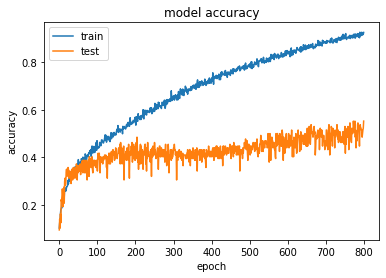

Test set accuracy: 55.22%


In [ ]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

score = model.evaluate(x_testcnn, y_test, verbose=0)
print("Test set " + "%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

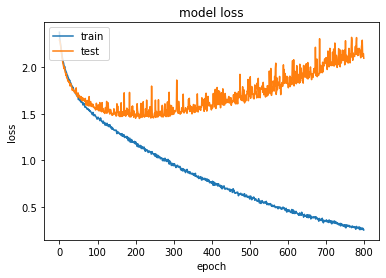

Test set accuracy: 55.22%


In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

score = model.evaluate(x_testcnn, y_test, verbose=0)
print("Test set " + "%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

## Saving the model

In [ ]:
model_name = 'mfcc_eng_CNN.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/mfcc_eng_CNN.h5 


In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading saved model

In [13]:
#run this cell when loading a model
#loading train test
import numpy as np
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
X_train=np.load('X_train.npy')
X_test=np.load('X_test.npy')
y_train=np.load('y_train.npy',allow_pickle=True)
y_test=np.load('y_test.npy',allow_pickle =True)

# X_test_final=np.load('X_test_final.npy',allow_pickle =True)
# y_test_final=np.load('y_test_final.npy',allow_pickle =True)
lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
# y_test_final = np_utils.to_categorical(lb.fit_transform(y_test_final))

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)
# x_testcnn_final= np.expand_dims(X_test_final, axis=2)

print(x_testcnn.shape)
print(x_testcnn.shape)

(134, 432, 1)
(134, 432, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
# loading json and creating model
from keras.models import model_from_json
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6) 
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("mfcc_eng_CNN.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], (score[1])*100))
loaded_model.summary()

Loaded model from disk
accuracy: 55.22%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 432, 128)          768       
_________________________________________________________________
activation (Activation)      (None, 432, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 432, 128)          82048     
_________________________________________________________________
activation_1 (Activation)    (None, 432, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 432, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 54, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D

## Predicting emotions on the test data

Label distribution in predictions

In [ ]:
preds = loaded_model.predict(x_testcnn, batch_size=32, verbose=1)
preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))
preddf = pd.DataFrame({'predictedvalues': predictions})
# preddf[:10]
preddf.value_counts()

5/5 [==============================] - 0s 2ms/step


predictedvalues
female_happy       19
female_fearful     18
male_sad           17
male_happy         14
male_angry         14
male_fearful       13
female_sad         13
female_calm        12
female_angry        8
male_calm           6
dtype: int64

Actual label distribution

In [ ]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))
actualdf = pd.DataFrame({'actualvalues': actualvalues})
print(actualdf.value_counts())

actualvalues  
male_sad          19
female_happy      18
female_fearful    17
male_angry        15
female_calm       14
female_angry      13
male_happy        11
male_fearful      10
female_sad        10
male_calm          7
dtype: int64


**Accuracies:**


1.   Predicting Gender
2.   Predicting Emotion
3.   Predicting Gender with Emotion



In [ ]:
print(len(actualdf),len(preddf))
gen = 0
gen_emotion = 0
emotion = 0
total = len(actualdf)
for i in range(total):
  gen_a = actualdf['actualvalues'][i].split("_")[0]
  gen_emotion_a = actualdf['actualvalues'][i]
  emotion_a = actualdf['actualvalues'][i].split("_")[1]

  gen_p = preddf['predictedvalues'][i].split("_")[0]
  gen_emotion_p = preddf['predictedvalues'][i]
  emotion_p = preddf['predictedvalues'][i].split("_")[1]

  if(gen_a == gen_p):
    gen+=1
  if(emotion_a == emotion_p):
    emotion+=1
  if(gen_emotion_a == gen_emotion_p):
    gen_emotion += 1

print("Test set Accuracy (Gender):", (gen/total)*100)
print("Test set Accuracy (Emotion):", (emotion/total)*100)
print("Test set Accuracy (Gender_Emotion):", (gen_emotion/total)*100)
finaldf = actualdf.join(preddf)


134 134
Test set Accuracy (Gender): 85.07462686567165
Test set Accuracy (Emotion): 63.43283582089553
Test set Accuracy (Gender_Emotion): 55.223880597014926


Evaluating Precision, Recall, F1-Score

In [ ]:
from sklearn.metrics import classification_report
y_true = list(actualdf['actualvalues'])
y_pred = list(preddf['predictedvalues'])
target_names = ['male_calm', 'male_angry', 'male_sad', 'female_calm', 'female_sad', 'female_fearful', 'male_happy', 'female_happy', 'male_fearful', 'female_angry']
print(classification_report(y_true, y_pred, target_names=target_names))

                precision    recall  f1-score   support

     male_calm       0.75      0.46      0.57        13
    male_angry       0.92      0.79      0.85        14
      male_sad       0.50      0.53      0.51        17
   female_calm       0.58      0.61      0.59        18
    female_sad       0.69      0.90      0.78        10
female_fearful       0.50      0.47      0.48        15
    male_happy       0.83      0.71      0.77         7
  female_happy       0.23      0.30      0.26        10
  male_fearful       0.36      0.45      0.40        11
  female_angry       0.47      0.42      0.44        19

      accuracy                           0.55       134
     macro avg       0.58      0.56      0.57       134
  weighted avg       0.57      0.55      0.56       134



## Actual v/s Predicted emotions

In [ ]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,13
female_calm,14
female_fearful,17
female_happy,18
female_sad,10
male_angry,15
male_calm,7
male_fearful,10
male_happy,11


In [ ]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,8
female_calm,12
female_fearful,18
female_happy,19
female_sad,13
male_angry,14
male_calm,6
male_fearful,13
male_happy,14


Writing the prediction.csv file

In [ ]:
finaldf.to_csv('Predictions.csv', index=False)